**Universidade Estadual de Campinas - Unicamp**

**Faculdade de Tecnologia - FT**

**Autor:** Ulisses Martins Dias

**Disciplina:** TT003 - Tópicos em Computação e Informática III

**Atividade 05:** Treinando uma Rede Neural com Valores de Estado

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ulissesdias/tt003/blob/main/atividades/atividade05.ipynb)

# Valores de Estado

Em sala de aula, vimos o seguinte cenário.

Temos um ambiente que fornece recompensas a uma agente que "anda" por um grid de maneira aleatória.


**Ambiente**: um grid $2 \times 2$ consistindo de apenas quatro estados.

**Estado**: temos apenas quatro estados, rotulados como A (NE), B (NO), C (SE) e D (SO).

**Ação**: consiste em mover para cima, baixo, esquerda e direita. Ações que sairiam do grid simplesmente mantém o agente no lugar.

1.  Digamos, por exemplo, que começamos no estado C, subir nos leva ao estado A.
2. Desse novo estado, se tentássemos nos mover para a esquerda, bateríamos em uma parede e permaneceríamos no estado A.
3. Seguir para a direita nos levaria para o estado B.
4. A partir daí, mover para baixo nos levaria ao estado D.

**Recompensa**: vamos assumir que
1. a recompensa é 0 ao chegar em todos os estados, exceto quando o agente chegar ao estado B.
2. Se o agente chegar ao estado B, receberá uma recompensa de +5.
* Isso inclui começar no estado B e bater em uma parede para permanecer em B.

**Política**: vamos considerar uma política que segue a distribuição uniforme de probabilidade. Em outras palavras, em qualquer estado, o agente tem 25% de probabilidade para se mover em qualquer direção.

Essas configurações podem ser resumidas na figura a seguir:

![alt text](http://www.ic.unicamp.br/~udias/si202/grid_world_01.png))

Também vimos em sala de aula uma abordagem clássica e uma ambordagem frequentista para computar o valor esperado do ganho acumulado quando o fator de desconto era $\gamma = 0.7$. O que percebemos é que, com o valor de desconto escolhido, o valor esperado do ganho acumulado se tornava o que mostramos a seguir:

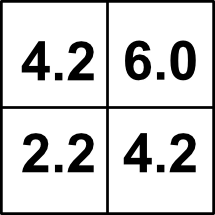

# Rede Neural

Você deve estar se perguntando: 'Onde a rede neural entra na jogada?'.

Bem, vamos usar a rede neural como nosso único mecanismo para guardar os valores de estado. Faremos isso ao tentar aprender esses valores de estado com uma abordagem clássica, ao fazer *bootstrapping*.

Em outras palavras, em sala de aula guardamos os valores de estado em variáveis na memória principal e íamos atualizando periodicamente essas variáveis com novos valores até convergir. Entretanto, agora queremos que uma rede neural guarde esses valores. Assim:

* A rede neural irá receber na entrada um estado. Você deve escolher por conta própria como representar um estado. Pode optar por um valor numérico (p. ex, 1,2,3,4), ou usar uma abordagem do tipo: $a = (1,0,0,0)$, $b = (0,1,0,0)$, e assim por diante.

* A rede deve fornecer como saída uma predição do valor esperado do ganho acumulado para aquele estado passado na entrada.

* A rede deve atualizar os valores dos pesos com uma função de custo apropriada.

**Observação Importante:** no laço de treinamento da rede neural, use os quatro estados para atualizar os pesos da rede neural, como se os quatro estados fossem um mini-batch se o problema fosse de aprendizado supervisionado. Em outras palavras, dentro do laço de treinamento da rede neural:

1. Use a própria rede neural para obter os valoress  esperados atuais de $a$, $b$, $c$ e $d$. Você fará isso pedindo à rede que forneça uma predição para esses estados.
2. Use o *bootstrapping* visto em sala de aula para computar os novos valores de $a$, $b$, $c$ e $d$.
3. Na função de custo, use os valores novos obtidos com o *bootstrapping* como *target*.
4. Execute o resto do treinamento como de costume.

sempre atualize os valores dos quatro estados

In [222]:
estados = [(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)]
acoes   = ["cima", "baixo", "esquerda", "direita"]
novos_estados = {
  1: {'cima': 1, 'baixo': 3, 'esquerda': 1, 'direita': 2},
  2: {'cima': 2, 'baixo': 4, 'esquerda': 1, 'direita': 2},
  3: {'cima': 1, 'baixo': 3, 'esquerda': 3, 'direita': 4},
  4: {'cima': 2, 'baixo': 4, 'esquerda': 3, 'direita': 4}
}
policy  = [0.25, 0.25, 0.25, 0.25]
rewards = [0, 5, 0, 0]
gamma   = 0.7

In [223]:
# Rede neural usando nn.Module
import torch.nn as nn

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork,self).__init__()
        self.input_layer    = nn.Linear(4,12)
        self.hidden_layer1  = nn.Linear(12,6)
        self.output_layer   = nn.Linear(6,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out =  self.sigmoid(self.input_layer(x))
        out =  self.sigmoid(self.hidden_layer1(out))
        out =  self.sigmoid(self.output_layer(out))
        return out

model = SimpleNeuralNetwork()

In [224]:
import torch

# pesos = torch.Tensor([0.0, 5.0, 0.0, 0.0])
loss_fn = nn.MSELoss()

In [225]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

current_values = [0,0,0,0]

for _ in range(20):  # Número de episódios
    for e, estado in enumerate(estados):
        next_value = []
        for a in acoes:
            predicted_value = model(torch.tensor(estado, dtype=torch.float32))
            novo_estado = novos_estados[e+1][a]
            novo_valor = model(torch.tensor(estados[novo_estado-1], dtype=torch.float32))

            next_value.append(predicted_value)

            target = policy[e] * (rewards[e] + gamma * novo_valor)
            loss = loss_fn(predicted_value, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Verificando a convergência
        diff_sum = sum(abs(current_values[i] - next_value[i]) for i in range(len(current_values)))
        if diff_sum <= 0.001:
            print("Convergiu")
        current_values = next_value

    print(loss.item())

0.03200695291161537
0.09033288806676865
0.06380893290042877
0.03994692116975784
0.010500631295144558
0.004018130712211132
0.002506560878828168
0.0019519295310601592
0.0016594096086919308
0.0014676254941150546
0.0013271966017782688
0.0012184353545308113
0.001131423399783671
0.0010602825786918402
0.0010011681588366628
Convergiu
0.0009514184785075486
Convergiu
0.0009091111132875085
Convergiu
0.0008728231769055128
Convergiu
0.0008414702606387436
Convergiu
0.0008142185397446156


# Forma de Avaliação

Nesta atividade, você será avaliado por cumprir os seguintes itens.

1. Consegue implementar uma rede neural.
2. Consegue escrever o código para treinamento da rede sem maiores imprecisões.
3. Consegue executar uma iteração do *bootstrapping*.
4. Consegue colocar o valor atual da rede e o valor do bootstrapping na função de custo.
5. Consegue analisar se a rede convergiu ou não para os valores de estado corretos.

Note que na etapa 5 não foi exigido que você faça a rede encontrar os valores de estado corretos. Algumas decisões não muito boas podem fazer você não conseguir resolver o problema, mesmo com o código correto, dado que algum *feeling* que você ainda não tem pode ser necessário.